# Task 1

## Data preparation

In [241]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GroupShuffleSplit, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [242]:
df = pd.read_csv('../../data/answerList_data.csv')
df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | (
            (df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


In [243]:
def calculate_ttr(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens) if tokens else 0
    return ttr


df['TTR'] = df['Answer.explanation'].astype(str).apply(calculate_ttr)

In [244]:
df['explanation_size'] = df['Answer.explanation'].astype(str).apply(len)
df['Answer.option.int'] = df['Answer.option'].map({'NO': 0, 'IDK': 0.5, 'YES': 1})
df['Worker.gender.int'] = df['Worker.gender'].map({'Male': -1, 'Other': 0, 'Female': 1})
df['Worker.profession.int'] = df['Worker.profession'].map(
    {'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer': 4})


In [245]:
df_holdout = df[df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]
df_train = df[~df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]

df_train_students = df_train[df_train['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_train_non_students = df_train[~df_train['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_holdout_students = df_holdout[df_holdout['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_holdout_non_students = df_holdout[
    ~df_holdout['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]

In [246]:
# We balance the dataset by taking the same number of samples for each class
def balance_df(df: pd.DataFrame) -> pd.DataFrame:
    df_0 = df[df['correctness'] == 0]
    df_1 = df[df['correctness'] == 1]

    if len(df_0) > len(df_1):
        df_0_balanced = df_0.sample(len(df_1))
        df_balanced = pd.concat([df_0_balanced, df_1])
    else:
        df_1_balanced = df_1.sample(len(df_0))
        df_balanced = pd.concat([df_0, df_1_balanced])

    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

    return df_balanced

In [247]:
df_train_students_balanced = balance_df(df_train_students)
df_train_students_balanced.groupby('correctness').size()

correctness
0    297
1    297
dtype: int64

In [248]:
df_train_non_students_balanced = balance_df(df_train_non_students)
df_train_non_students_balanced.groupby('correctness').size()


correctness
0    562
1    562
dtype: int64

In [249]:
input_cols = ['Worker.score', 'Answer.duration', 'TTR', 'explanation_size', 'Answer.confidence',
              'Answer.difficulty'] # only use these input columns, because specified in the task
output_col = 'correctness'


---
# Evaluating the classifier on student and non-student data

Training a RandomForestClassifier on the student-only train set and comparing predictions on student-only vs non-student holdout set: 

In [250]:
def evaluate_model(df_train, df_holdout_students, df_holdout_non_students):

    clf = RandomForestClassifier(random_state=42)
    clf.fit(df_train[input_cols], df_train[output_col])

    student_precision = precision_score(df_holdout_students[output_col], clf.predict(df_holdout_students[input_cols]))
    student_recall = recall_score(df_holdout_students[output_col], clf.predict(df_holdout_students[input_cols]))

    non_student_precision = precision_score(df_holdout_non_students[output_col], clf.predict(df_holdout_non_students[input_cols]))
    non_student_recall = recall_score(df_holdout_non_students[output_col], clf.predict(df_holdout_non_students[input_cols]))

    return student_precision, student_recall, non_student_precision, non_student_recall

def evaluate_model_print(df_train, df_holdout_students, df_holdout_non_students):
    student_precision, student_recall, non_student_precision, non_student_recall = evaluate_model(df_train, df_holdout_students, df_holdout_non_students)

    print("Student precision:", np.mean(student_precision))
    print("Student recall:", np.mean(student_recall))
    print("Student F1 score:", 2 * np.mean(student_precision) * np.mean(student_recall) / (np.mean(student_precision) + np.mean(student_recall)))
    print("Non-student precision:", np.mean(non_student_precision))
    print("Non-student recall:", np.mean(non_student_recall))
    print("Non-student F1 score:", 2 * np.mean(non_student_precision) * np.mean(non_student_recall) / (np.mean(non_student_precision) + np.mean(non_student_recall)))

In [251]:
evaluate_model_print(df_train_students_balanced, df_holdout_students, df_holdout_non_students)

Student precision: 0.726027397260274
Student recall: 0.7681159420289855
Student F1 score: 0.7464788732394365
Non-student precision: 0.78125
Non-student recall: 0.8064516129032258
Non-student F1 score: 0.7936507936507936


We expected the classifier to perform better on the student-only holdout set, because it was explicitly trained on student-only data (and we expect the non-student data to differ).
Strangely, the F1 score is even slightly better when predicting on the non-student data.
We inspect the data to gain a better understanding of these results.

In [252]:
print(df_holdout_students[output_col].describe())
print(df_holdout_students[input_cols].describe())


count    103.000000
mean       0.669903
std        0.472547
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: correctness, dtype: float64
       Worker.score  Answer.duration         TTR  explanation_size  \
count    103.000000       103.000000  103.000000        103.000000   
mean       3.970874       231.341951    0.899959        154.543689   
std        0.868358       277.551315    0.098046        168.151179   
min        3.000000        17.746000    0.519481         11.000000   
25%        3.000000        86.631000    0.840407         58.500000   
50%        4.000000       148.875000    0.923077         98.000000   
75%        5.000000       249.111500    1.000000        165.000000   
max        5.000000      2105.108000    1.000000        970.000000   

       Answer.confidence  Answer.difficulty  
count         103.000000         103.000000  
mean            3.864078           2.446602  
std             1.527837           1.

In [253]:
print(df_holdout_non_students[output_col].describe())
print(df_holdout_non_students[input_cols].describe())


count    217.000000
mean       0.714286
std        0.452798
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: correctness, dtype: float64
       Worker.score  Answer.duration         TTR  explanation_size  \
count    217.000000       217.000000  217.000000        217.000000   
mean       4.271889       471.678005    0.890624        150.428571   
std        0.830435      1263.769459    0.096088        116.544562   
min        3.000000         7.328000    0.581818          2.000000   
25%        4.000000        70.300000    0.826087         64.000000   
50%        5.000000       133.565000    0.900000        130.000000   
75%        5.000000       322.857000    1.000000        194.000000   
max        5.000000     10791.162000    1.000000        591.000000   

       Answer.confidence  Answer.difficulty  
count         217.000000         217.000000  
mean            3.986175           2.626728  
std             1.267395           1.

We see that the input columns have a pretty similar structure. Only the explanation size and the answer confidence means differ about 10%. The average answer duration is way higher for the non-students, but this seems to be caused by the extreme high maximum value that seems to be an outlier.
More interesting is the difference in the output values that we try to predict: In the non-student holdout set we see a 'mean' of 0.71 which means that we have more positives than negatives in this data. In comparison, for the student-only data it is closer to 50%. 
Lets use our balancing to see whether this might be the cause.

In [254]:
df_holdout_students_balanced = balance_df(df_holdout_students)
df_holdout_students_balanced.groupby('correctness').size()

correctness
0    34
1    34
dtype: int64

In [255]:
df_holdout_non_students_balanced = balance_df(df_holdout_non_students)
df_holdout_non_students_balanced.groupby('correctness').size()

correctness
0    62
1    62
dtype: int64

In [256]:

evaluate_model_print(df_train_students_balanced, df_holdout_students_balanced, df_holdout_non_students_balanced)


Student precision: 0.6
Student recall: 0.8823529411764706
Student F1 score: 0.7142857142857143
Non-student precision: 0.5783132530120482
Non-student recall: 0.7741935483870968
Non-student F1 score: 0.6620689655172414


Here the results are as expected. This strengthens our hypotheses that the bad results of the classifier trained on student-only data predicting non-student data points might be due to the distribution of the data.

---

## Question 1: Gradually adding more non-students to the holdout set

We see a clear downward trend for the recall if we gradually add more and more non-student data to the holdout set.
For the recall, a loss of 5% is reached with 50% non-student data added. With more non-student data, it further decreases but does not come down to a 10% loss.

The precision seems to have random ups and downs around 0.6, so we cannot really determine a ratio for when it drops by 5% or more.


(original recall: 0.885 -> 5% loss: 0.84, 10% loss: 0.797)
(original precision: 0.6 -> 5% loss: 0.57, 10% loss: 0.54)

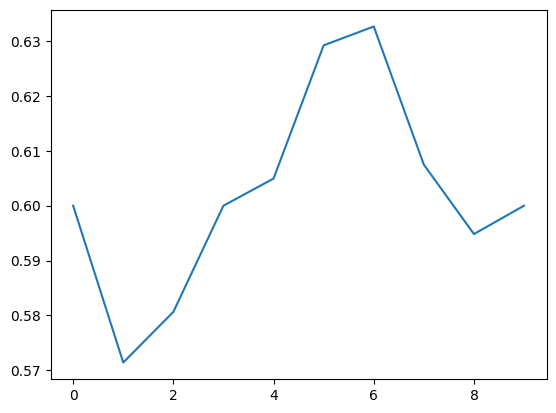

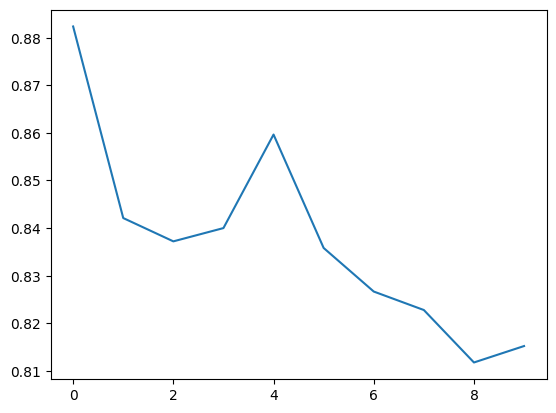

In [257]:
precisions = []
recalls = []
for i in range(10):
    # add i*10% from non-student data to student data
    non_student_data_points = df_holdout_non_students_balanced.sample(frac=0.1*i, random_state=0)
    df_holdout_mixed = pd.concat([df_holdout_students_balanced, non_student_data_points])
    _, _, non_student_precision, non_student_recall = evaluate_model(df_train_students_balanced, df_holdout_students, df_holdout_mixed)
    precisions.append(np.mean(non_student_precision))
    recalls.append(np.mean(non_student_recall))

plt.plot(precisions, label='Precision')
plt.show()
plt.plot(recalls, label='Recall')
plt.show()
    

---
## Question 2: Gradually adding non-students to train data

Here again, we can see the upward trend as expected, but it is not very strong. Both precision and recall are pretty far away from the original model's performance.

We wonder why the balancing of the input and output data has such a strong effect on our model's performance while making the holdout data more similar to the train data (or the other way around) does not really have a high impact. Our assumption is that the model does not really generalize so it is very affected by changes to class distribution. 

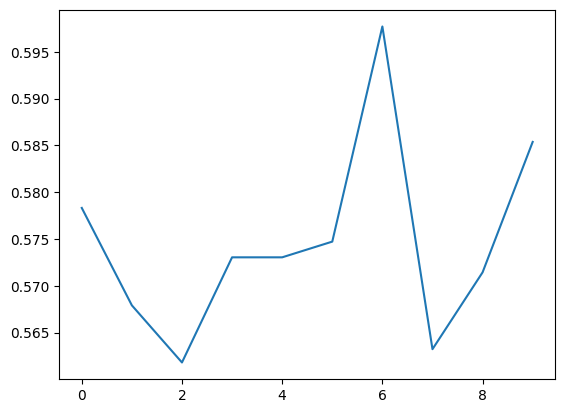

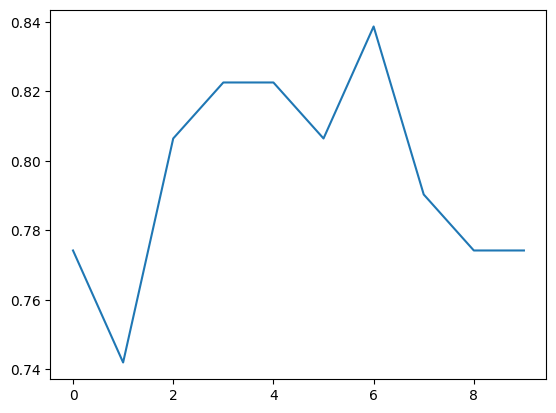

In [261]:
precisions = []
recalls = []
for i in range(10):
    # add i*10% from non-student data to student data
    non_student_data_points = df_train_non_students_balanced.sample(frac=0.1*i, random_state=42)
    df_train_mixed = pd.concat([df_train_students_balanced, non_student_data_points])
    _, _, non_student_precision, non_student_recall = evaluate_model(df_train_mixed, df_holdout_students, df_holdout_non_students_balanced)
    precisions.append(np.mean(non_student_precision))
    recalls.append(np.mean(non_student_recall))

plt.plot(precisions, label='Precision')
plt.show()
plt.plot(recalls, label='Recall')
plt.show()

In [262]:
evaluate_model_print(df_train, df_holdout, df_holdout)

Student precision: 0.7638376383763837
Student recall: 0.9241071428571429
Student F1 score: 0.8363636363636364
Non-student precision: 0.7638376383763837
Non-student recall: 0.9241071428571429
Non-student F1 score: 0.8363636363636364
